# LISA Microscope Workflow

**Author**: Ciaran Breen

**Date**: 25/08/2025

**Description**: This notebook demonstrates the current workflow for the modelling of scattered light due to surface porosity for samples measured using the microscope in the LISA cleanroom.

## Workflow Steps
The workflow consists of the following steps:

1. Measure mirror surface with using LISA microscope

2. Use image segmentation to identify and extract surface pores

3. Analyze extracted pores to calculate shape, area, distribution etc.

4. Use Peterson model to calculate BRDF contribution from the pores

5. Integrate BRDF to get TIS (To do)



In [62]:
# import libraries
import numpy as np
from PIL import Image
import skimage as ski
import matplotlib.pyplot as plt
from amsurf.segment import glob_thresh
from amsurf.BRDF import BRDF_dig_sum
import matplotlib as mpl
from matplotlib.patches import Rectangle
from scipy.ndimage import binary_fill_holes
import pandas as pd

# global plotting parameters
mpl.rcParams['font.size'] = 14
%matplotlib inline

## 1. Measure mirror surface with using LISA microscope

The microscope in the LISA cleanroom is used to measure the surface of the mirror. The microscope captures high-resolution images of the surface. Pores on the surface appear as dark spots in the images.

The image below shows an example of a surface measured using the LISA microscope. It is a composite image made up of multiple smaller images stitched together.

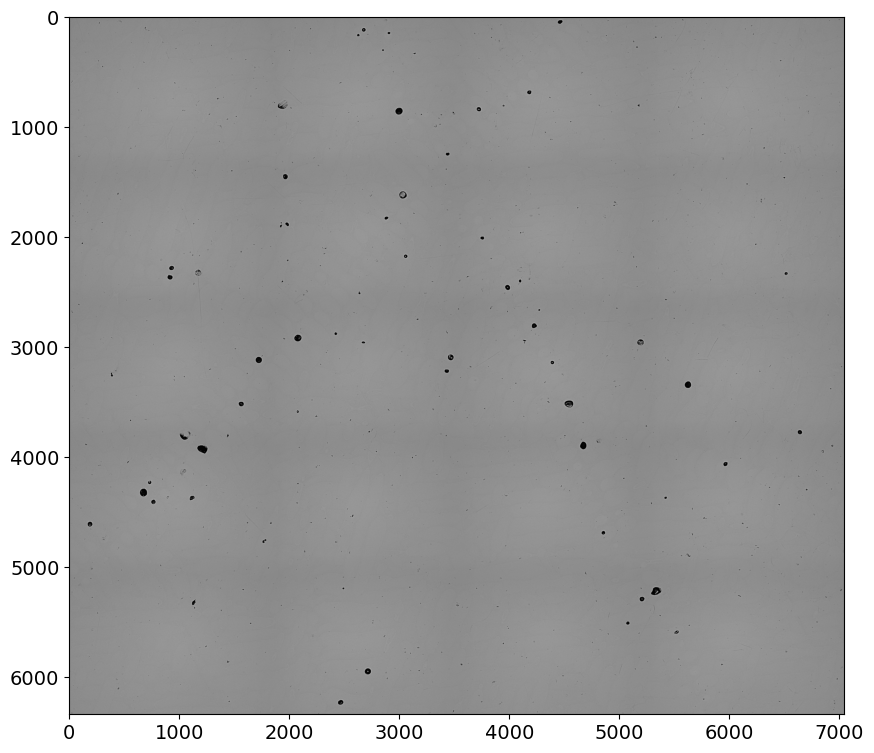

In [63]:
# load the data
img_path = "../data/raw/SAMPLE_03_IA_flat/20250502_IA_CCAM_M5/Acquisition_08.tif"
img = Image.open(img_path).convert("L") # Convert to grayscale
img_arr = np.array(img) # Convert to numpy array for scikit-image processing

# plot the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
plt.show()

Pore shapes can be irregular but are generally circular or elliptical. We define a lower size limit of 20 microns for pores to be included in the analysis. This is somewhat arbitrary but is based on our understanding of pore formation in the AM samples. Dark spots smaller than this are likely to be either noise (1-2 pixels), contamination, or oxide inclusions rather than true pores.

See below a zoomed-in section of the image showing some example pores.

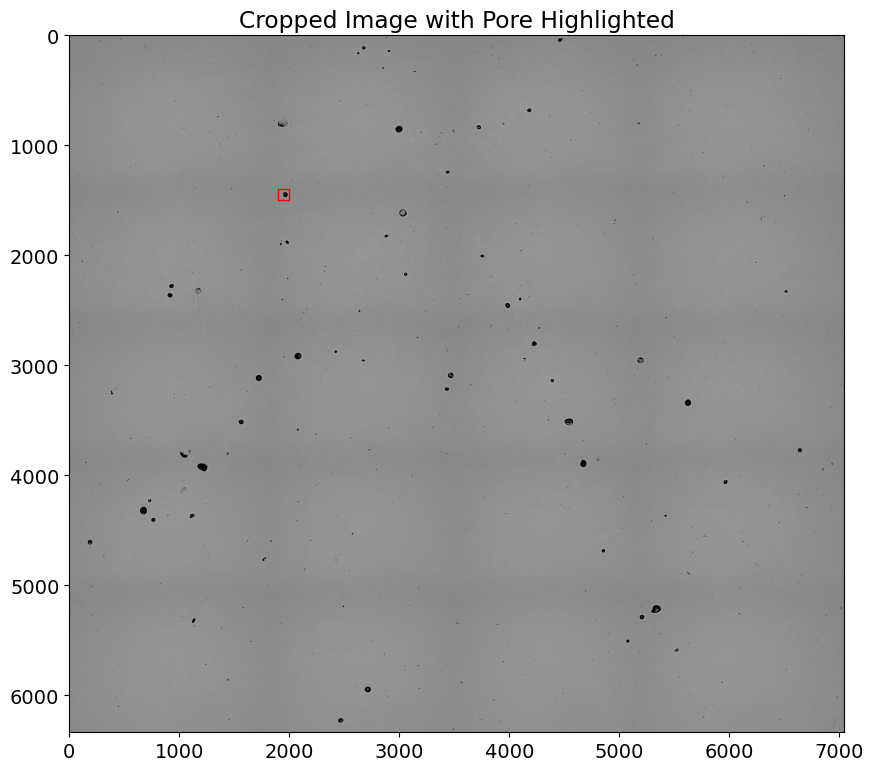

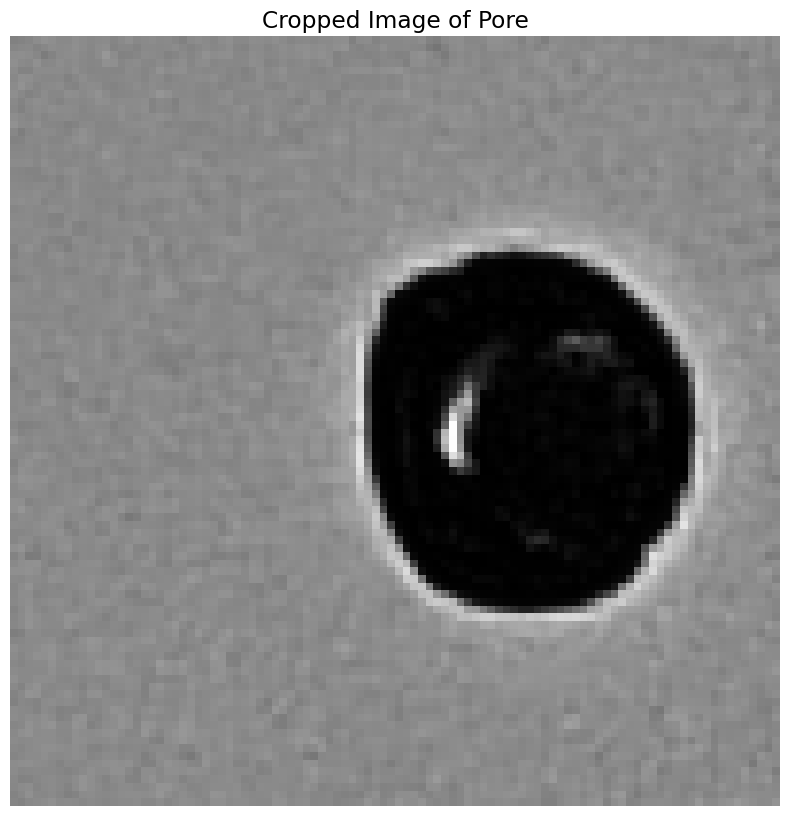

In [64]:
# zoom in on a pore
crop_lims = (1900, 1400, 2000, 1500)  # Define the crop limits (left, upper, right, lower)
crop_img = img.crop((crop_lims[0], crop_lims[1], crop_lims[2], crop_lims[3]))
crop_img_arr = np.array(crop_img)

crop_rect = Rectangle((crop_lims[0], crop_lims[1]),
                      crop_lims[2] - crop_lims[0],
                      crop_lims[3] - crop_lims[1],
                      linewidth=1,
                      edgecolor='r',
                      facecolor='none')

# plot the cropped image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
ax.add_patch(crop_rect)
ax.set_title('Cropped Image with Pore Highlighted')

# plot the cropped image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(crop_img_arr, cmap='gray', vmin=0, vmax=255)
ax.set_title('Cropped Image of Pore')
ax.axis('off')
plt.show()

## 2. Use image segmentation to identify and extract surface pores

Pores are identified using image segmentation techniques. The goal is to create a binary mask where pores are marked as foreground (1) and the rest of the surface as background (0). For LISA microscope images, pores are well-defined dark spots against a lighter background, making segmentation relatively straightforward.

For this dataset, we use a global thresholding method to segment the pores. The threshold value is chosen based on the histogram of pixel intensities in the image. Pixels with intensities below the threshold are classified as within pores, while those above are classified as background.

The segmentation process is based inspired by techniques from bioimage analsysis and flourecence microscopy. Specifically the "Measure fluorescence intensity at the nuclear envelope" example at https://scikit-image.org/docs/stable/auto_examples/applications/index.html and "Introduction to Bioimage Analysis" at https://bioimagebook.github.io/index.html

### Gaussian Blur

To reduce noise and improve segmentation accuracy, we first apply a Gaussian blur to the image. This smooths out small variations in pixel intensity that could lead to false positives in pore detection. The standard deviation (sigma) of the Gaussian kernel should be chose to balance noise reduction with preservation of pore edges. A sigma value of 2 is used here.

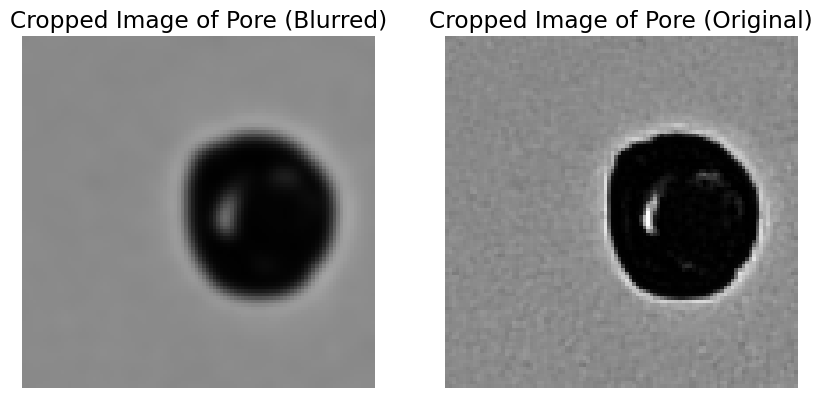

In [65]:
blurred_img = ski.filters.gaussian(img_arr, sigma=2, preserve_range=True)

# plot a comparison of the original and blurred images on cropped region
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(blurred_img[crop_lims[1]:crop_lims[3], crop_lims[0]:crop_lims[2]], cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Cropped Image of Pore (Blurred)')
ax[0].axis('off')
ax[1].imshow(img_arr[crop_lims[1]:crop_lims[3], crop_lims[0]:crop_lims[2]], cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Cropped Image of Pore (Original)')
ax[1].axis('off')
plt.show()



### Thresholding

The histogram of pixel intensities for the full image is shown below. The threshold value is chosen to separate the dark pores from the lighter background. Three methods are used to determine the threshold: Otsu's method, the triangle method, and mean absolute deviation thresholding (MAD). 

Triangle threshold: 133.48336909868323
Otsu threshold: 85.41682681606324
MAD threshold: 122.22630399417369


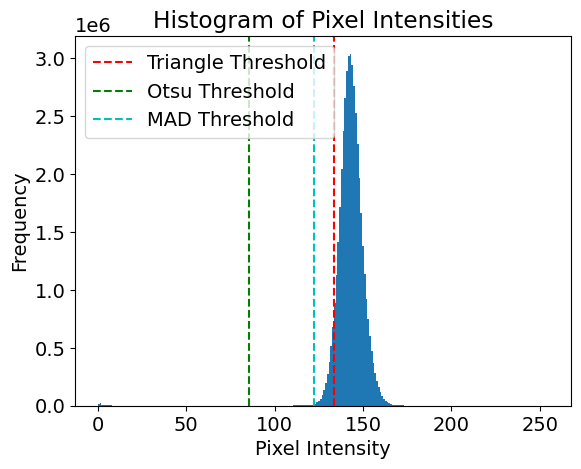

In [66]:
def threshold_mad(im: np.ndarray, k=6):
    med = np.median(im)
    mad = np.median(np.abs(im.astype(np.float32) - med))
    return med - mad * k * 1.4826

tri_thresh = ski.filters.threshold_triangle(blurred_img)
otsu_thresh = ski.filters.threshold_otsu(blurred_img)
mad_thresh = threshold_mad(blurred_img)

print(f"Triangle threshold: {tri_thresh}")
print(f"Otsu threshold: {otsu_thresh}")
print(f"MAD threshold: {mad_thresh}")

# plot the histogram
fig, ax = plt.subplots()
ax.hist(img_arr.ravel(), bins=256)
ax.axvline(tri_thresh, color='r', linestyle='--', label='Triangle Threshold')
ax.axvline(otsu_thresh, color='g', linestyle='--', label='Otsu Threshold')
ax.axvline(mad_thresh, color='c', linestyle='--', label='MAD Threshold')
ax.legend()
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Pixel Intensities')
plt.show()

The histogram is huge and dominated by the background pixels. Plotting the y-axis on a log scale helps to visualise the pore pixels better.

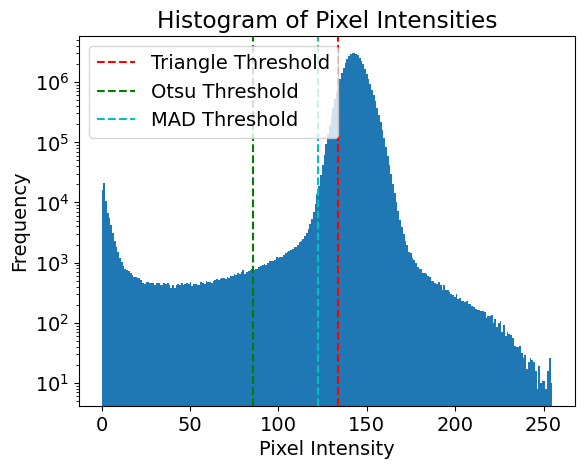

In [67]:
# plot the histogram
fig, ax = plt.subplots()
ax.hist(img_arr.ravel(), bins=256)
ax.axvline(tri_thresh, color='r', linestyle='--', label='Triangle Threshold')
ax.axvline(otsu_thresh, color='g', linestyle='--', label='Otsu Threshold')
ax.axvline(mad_thresh, color='c', linestyle='--', label='MAD Threshold')

ax.legend()
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.set_title('Histogram of Pixel Intensities')
plt.show()

With the threshold determined, we create a binary mask of the image. Pixels with intensities below the threshold are set to 1 (pore), and those above are set to 0 (background).

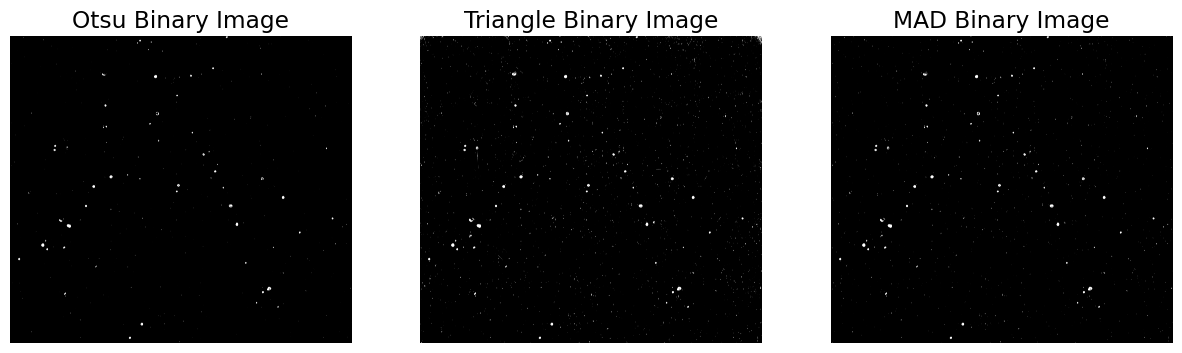

In [68]:
otsu_binary = blurred_img < otsu_thresh
tri_binary = blurred_img < tri_thresh
mad_binary = blurred_img < mad_thresh

# plot the binary images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(otsu_binary, cmap='gray')
ax[0].set_title('Otsu Binary Image')
ax[0].axis('off')
ax[1].imshow(tri_binary, cmap='gray')
ax[1].set_title('Triangle Binary Image')
ax[1].axis('off')
ax[2].imshow(mad_binary, cmap='gray')
ax[2].set_title('MAD Binary Image')
ax[2].axis('off')
plt.show()

### Fill in holes and clear border objects

Pores often have some internal structure or that can create holes in the binary. These internal sctructures should be considered part of the pore. They are just variations in depth within the pore and, within the assumptions of our scattering model, will contribute to scattering. We use morphological hole filling to fill in these internal holes.

We also remove any pores that touch the image border. These are likely to be partial pores that are not fully captured in the image and could skew the analysis.

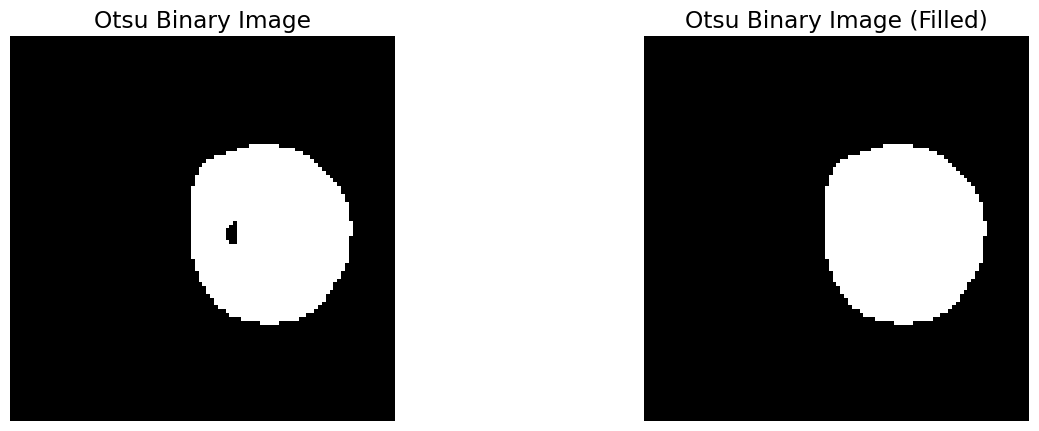

In [69]:
filled_otsu = binary_fill_holes(otsu_binary)
filled_tri = binary_fill_holes(tri_binary)
filled_mad = binary_fill_holes(mad_binary)

cleared_otsu = ski.segmentation.clear_border(filled_otsu)
cleared_tri = ski.segmentation.clear_border(filled_tri)
cleared_mad = ski.segmentation.clear_border(filled_mad)

# plot an example of hole filling
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(otsu_binary[crop_lims[1]:crop_lims[3], crop_lims[0]:crop_lims[2]], cmap='gray')
ax[0].set_title('Otsu Binary Image')
ax[0].axis('off')
ax[1].imshow(filled_otsu[crop_lims[1]:crop_lims[3], crop_lims[0]:crop_lims[2]], cmap='gray')
ax[1].set_title('Otsu Binary Image (Filled)')
ax[1].axis('off')
plt.show()

### Label pores

Finally, we label the connected components in the binary mask to identify individual pores. Each pore is assigned a unique label, which allows us to analyze their properties (size, shape, location) in subsequent steps.

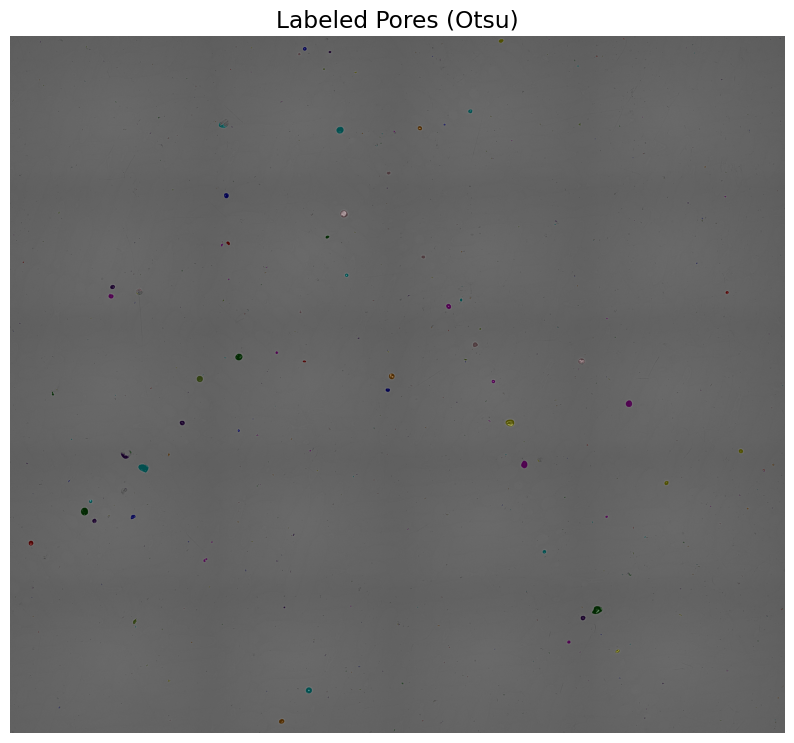

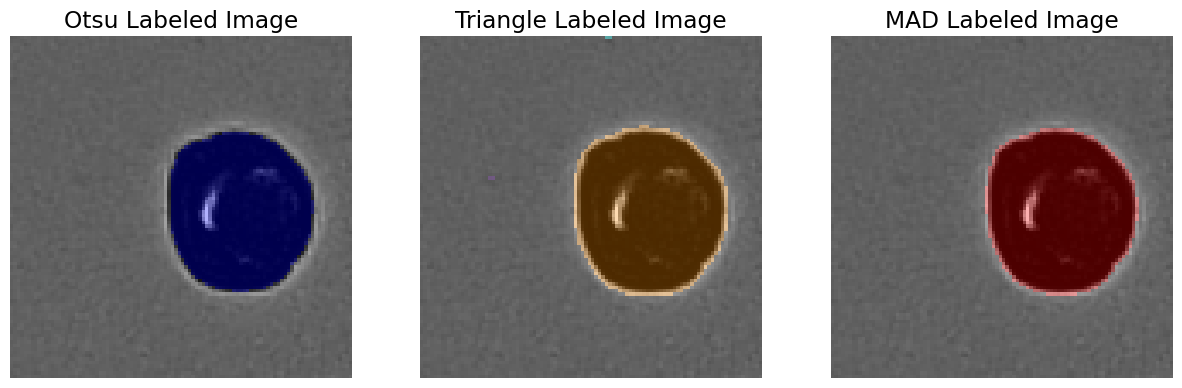

In [70]:
label_otsu = ski.measure.label(cleared_otsu)
label_tri = ski.measure.label(cleared_tri)
label_mad = ski.measure.label(cleared_mad)

# plot the labeled images
label_arr_otsu = ski.color.label2rgb(label_otsu, bg_label=0, image=img_arr)
label_arr_tri = ski.color.label2rgb(label_tri, bg_label=0, image=img_arr)
label_arr_mad = ski.color.label2rgb(label_mad, bg_label=0, image=img_arr)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(label_arr_otsu)
ax.set_title('Labeled Pores (Otsu)')
ax.axis('off')

# zoom in on a pore and compare methods
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(label_arr_otsu[crop_lims[1]:crop_lims[3], crop_lims[0]:crop_lims[2]], cmap='gray')
ax[0].set_title('Otsu Labeled Image')
ax[0].axis('off')
ax[1].imshow(label_arr_tri[crop_lims[1]:crop_lims[3], crop_lims[0]:crop_lims[2]], cmap='gray')
ax[1].set_title('Triangle Labeled Image')
ax[1].axis('off')
ax[2].imshow(label_arr_mad[crop_lims[1]:crop_lims[3], crop_lims[0]:crop_lims[2]], cmap='gray')
ax[2].set_title('MAD Labeled Image')
ax[2].axis('off')
plt.show()


## 3. Analyze extracted pores to calculate shape, area, distribution etc.

With the pores identified and labeled, we can now analyze their properties. For the scattering analysis, we are particularly interested in the size (area) of the pores, as this will influence their contribution to the overall BRDF. An assumption is made that pores are circular for the purposes of the scattering model, so we calculate an equivalent diameter for each pore based on its area (i.e. assuming a circular shape with the same area.)

This can be done using regionprops from skimage.measure, which provides various properties of labeled regions in a binary image. Regionprops can calculate area, centroid, and equivalent diameter, among other properties (see https://scikit-image.org/docs/0.25.x/api/skimage.measure.html#skimage.measure.regionprops). Custom properties can also be defined if needed. Here we calculate area, centroid, and equivalent diameter.

In [81]:
regions_otsu = ski.measure.regionprops_table(label_otsu, properties=('label', 'area', 'centroid', 'equivalent_diameter'))
regions_tri = ski.measure.regionprops_table(label_tri, properties=('label', 'area', 'centroid', 'equivalent_diameter'))
regions_mad = ski.measure.regionprops_table(label_mad, properties=('label', 'area', 'centroid', 'equivalent_diameter'))

df_otsu = pd.DataFrame(regions_otsu).set_index('label')
df_tri = pd.DataFrame(regions_tri).set_index('label')
df_mad = pd.DataFrame(regions_mad).set_index('label')

df_otsu.head()


,area,centroid-0,centroid-1,equivalent_diameter
label,,,,
1,53.0,24.886792,5579.641509,8.214724
2,9.0,23.000000,7000.000000,3.385138
3,1124.0,44.133452,4463.975089,37.830163
4,20.0,31.700000,4900.100000,5.046265
5,10.0,42.500000,473.000000,3.568248


For the BRDF calculation, we need the pore diameter in meters. A scaling factor will need to be applied based on the microscope's pixel size (e.g., 1.38 microns per pixel). This is currently hardcoded but should be extracted from the image metadata in future.

In [82]:
pix_size = 1.3e-6  # pixel size in meters (1.2 microns)
img_size = (img_arr.shape[0] * pix_size, img_arr.shape[1] * pix_size)  # image size in meters
img_area = img_size[0] * img_size[1]

print(f"Image size: {img_size[0]:.2e} m x {img_size[1]:.2e} m")
print(f"Image area: {img_area:.2e} m^2")

df_otsu['equivalent_diameter_m'] = df_otsu['equivalent_diameter'] * pix_size
df_tri['equivalent_diameter_m'] = df_tri['equivalent_diameter'] * pix_size
df_mad['equivalent_diameter_m'] = df_mad['equivalent_diameter'] * pix_size

df_otsu.head()


Image size: 8.24e-03 m x 9.16e-03 m
Image area: 7.54e-05 m^2


,area,centroid-0,centroid-1,equivalent_diameter,equivalent_diameter_m
label,,,,,
1,53.0,24.886792,5579.641509,8.214724,0.000011
2,9.0,23.000000,7000.000000,3.385138,0.000004
3,1124.0,44.133452,4463.975089,37.830163,0.000049
4,20.0,31.700000,4900.100000,5.046265,0.000007
5,10.0,42.500000,473.000000,3.568248,0.000005


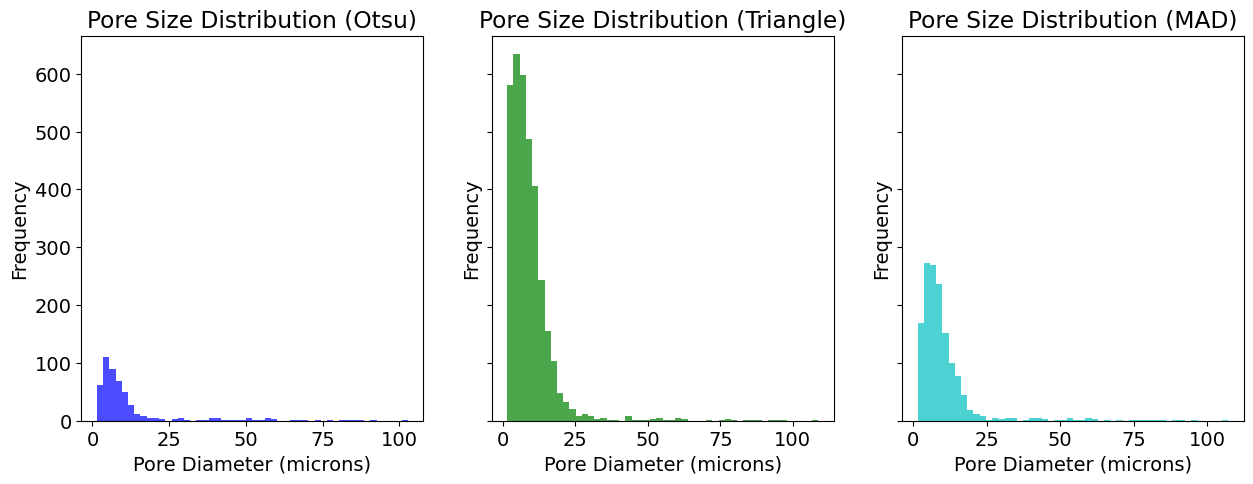

In [84]:
# show histogram of pore sizes
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].hist(df_otsu['equivalent_diameter_m'] * 1e6, bins=50, color='b', alpha=0.7)
ax[0].set_title('Pore Size Distribution (Otsu)')
ax[0].set_xlabel('Pore Diameter (microns)')
ax[0].set_ylabel('Frequency')
ax[1].hist(df_tri['equivalent_diameter_m'] * 1e6, bins=50, color='g', alpha=0.7)
ax[1].set_title('Pore Size Distribution (Triangle)')
ax[1].set_xlabel('Pore Diameter (microns)')
ax[1].set_ylabel('Frequency')
ax[2].hist(df_mad['equivalent_diameter_m'] * 1e6, bins=50, color='c', alpha=0.7)
ax[2].set_title('Pore Size Distribution (MAD)')
ax[2].set_xlabel('Pore Diameter (microns)')
ax[2].set_ylabel('Frequency')
plt.show()

It is important to distinguish between contamination, scatches, and true pores in the analysis. Contamination and scratches can also appear as dark regions in the image but do not scatter light in the same way as pores. Assumptions made in the Peterson model for pore scattering will likely not hold for these features. Therefore, we need to filter out these non-pore features from the analysis. This can be done based on size (e.g., excluding very small or very large features), shape (e.g., excluding highly elongated features), or other criteria.

Here we simply filter out very small features (less than 20 microns in diameter) as these are unlikely to be true pores. This size threshold can be adjusted based on the specific characteristics of the dataset and the requirements of the analysis. 

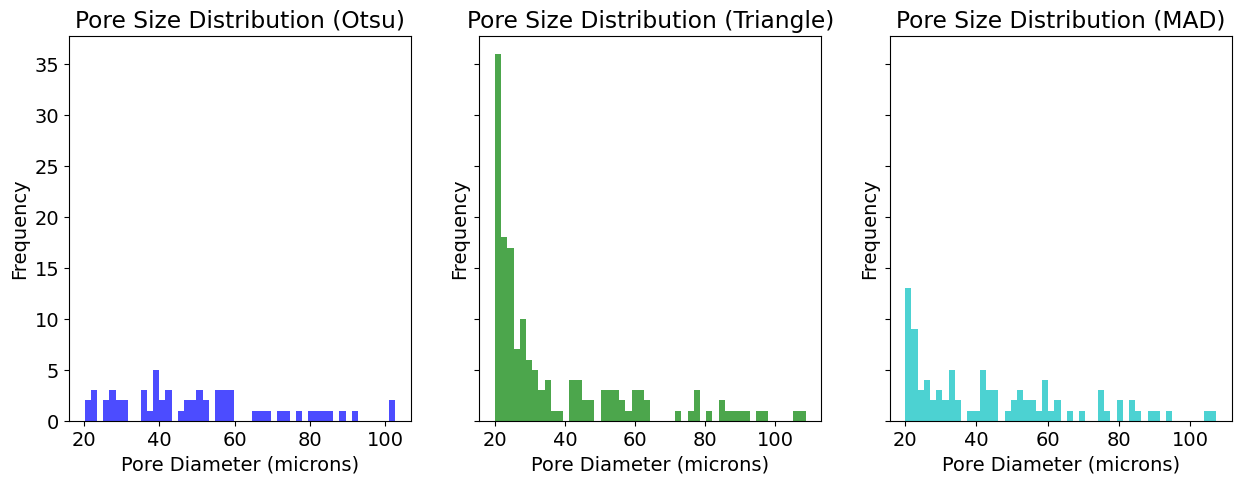

In [86]:
# filter out small pores (less than 20 microns in diameter)
min_diameter = 20e-6  # 20 microns in meters
df_otsu_fltrd = df_otsu[df_otsu['equivalent_diameter_m'] >= min_diameter]
df_tri_fltrd = df_tri[df_tri['equivalent_diameter_m'] >= min_diameter]
df_mad_fltrd = df_mad[df_mad['equivalent_diameter_m'] >= min_diameter]

# show histogram of pore sizes after filtering
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].hist(df_otsu_fltrd['equivalent_diameter_m'] * 1e6, bins=50, color='b', alpha=0.7)
ax[0].set_title('Pore Size Distribution (Otsu)')
ax[0].set_xlabel('Pore Diameter (microns)')
ax[0].set_ylabel('Frequency')
ax[1].hist(df_tri_fltrd['equivalent_diameter_m'] * 1e6, bins=50, color='g', alpha=0.7)
ax[1].set_title('Pore Size Distribution (Triangle)')
ax[1].set_xlabel('Pore Diameter (microns)')
ax[1].set_ylabel('Frequency')
ax[2].hist(df_mad_fltrd['equivalent_diameter_m'] * 1e6, bins=50, color='c', alpha=0.7)
ax[2].set_title('Pore Size Distribution (MAD)')
ax[2].set_xlabel('Pore Diameter (microns)')
ax[2].set_ylabel('Frequency')
plt.show()

## 4. Use Peterson model to calculate BRDF contribution from the pores

The Peterson model is used to calculate the BRDF contribution from the pores based on their size and distribution. The model has been adapted to sum the individual contributions from each pore to get the total BRDF instead of using an average pore size.

$$    \rho_d = \frac{1}{4 A} \sum_{i=0}^n d_i^2 \left(1 + \frac{\pi^2 d_i^2}{4 \lambda^2}\left(1 + \frac{\sin^2(\theta)}{l_{i}^2}\right)^{-3/2}\right) $$

where:
- $ \rho_d $ is the the BRDF due to the pores
- $ A $ is the total area of the surface being analyzed
- $ d_i $ is the diameter of pore \( i \)
- $ \lambda $ is the wavelength of the incident light
- $ \theta $ is the scattering angle
- $ l_i $ i the roll-off angle for pore \( i \) and is defined as:

$$ l_d = \left(\frac{4}{\pi^4}\right)^{1/3} \frac{\lambda}{d} $$

See paper for more details.

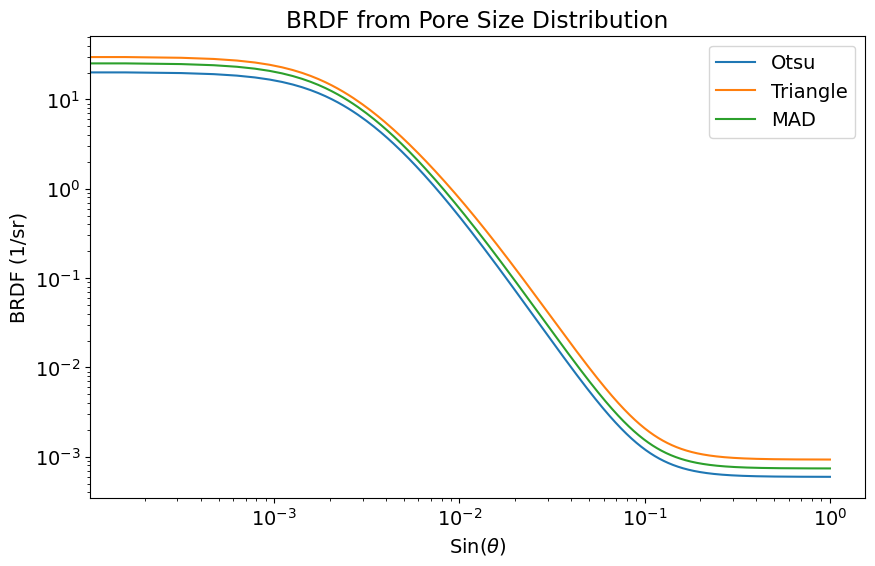

In [105]:
lamda = 0.6e-6  # wavelength in meters (1 micron)
theta = np.linspace(0, np.pi/2, 10000) # scattering angles from 0.001 to 90 degrees

brdf_otsu = BRDF_dig_sum(df_otsu_fltrd['equivalent_diameter_m'].to_numpy(), img_area, lamda, theta)
brdf_tri = BRDF_dig_sum(df_tri_fltrd['equivalent_diameter_m'].to_numpy(), img_area, lamda, theta)
brdf_mad = BRDF_dig_sum(df_mad_fltrd['equivalent_diameter_m'].to_numpy(), img_area, lamda, theta)

# plot the BRDF results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.sin(theta), brdf_otsu, label='Otsu')
ax.plot(np.sin(theta), brdf_tri, label='Triangle')
ax.plot(np.sin(theta), brdf_mad, label='MAD')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Sin($\theta$)')
ax.set_ylabel('BRDF (1/sr)')
ax.set_title('BRDF from Pore Size Distribution')
ax.legend()
plt.show()